# Clustering sentence embeddings to identify intents in short text
Hyperparameter tuning of UMAP + HDBSCAN to determine the number of clusters in unlabeled text data
TL;DR The unsupervised learning problem of clustering short-text messages can be turned into a constrained optimization problem to automatically tune UMAP + HDBSCAN hyperparameters. The chatintents package makes it easy to implement this tuning process.

# GOAL
Defining the goal
Before we go further, let’s first define what we’re trying to do. Here I’m interested in answering the question:

given an unlabeled set of dialogues between a user and some company representative, is there a way to obtain a helpful labeling of user intents in an automated way?

In [1]:
#pip install contractions
#!pip install -U pip setuptools wheel
#!pip install -U spacy
#!python -m spacy download en_core_web_sm
#!pip install bertopic
#!pip install yellowbrick
#!pip install distance
#!pip install transformers
#!pip install tensorflow

In [2]:
!pip install "tensorflow>=2.0.0"
!pip install --upgrade tensorflow-hub

In [3]:
import pandas as pd
import numpy as np
import unicodedata
import re
import contractions
import string
import distance

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tnrange

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import normalized_mutual_info_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation

from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
sns.set() 

#spacy
import spacy
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()
import textwrap
stops = set(stopwords.words('english'))

#from bertopic import BERTopic
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/yellowbrick/style/colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
/Users/ankush.singal/opt/anaconda3/lib/py

In [4]:
df = pd.read_csv('Created_Cases - databricks.csv',usecols=["Case title"])
df.head()

,Case title
0,genie
1,genie
2,jproperties library installation issue
3,Union with Null
4,Spark ReadStream fails to infer schema


# SAMPLING 

In [5]:
data_sample = df.sample(1000, random_state=123)

In [6]:
data_sample.head()


,Case title
1129,2205130050001971 genie
7071,Have access to both DBFS in S3 and Glue Catalo...
7431,External Jars not uploading in databricks
6254,Streaming query Exception : exception thrown a...
2357,2204190030002027 - genie


In [7]:
all_intents = list(data_sample['Case title'])

In [8]:
# define the document embedding models to use for comparison
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('paraphrase-mpnet-base-v2')



def embed(model, model_type, sentences):
  
    if model_type == 'use':
            embeddings = model(sentences)
    elif model_type == 'sentence transformer':
            embeddings = model.encode(sentences)
    return embeddings

# generate embeddings for each model
embeddings_use = embed(model_use, 'use', all_intents)
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)

embeddings = ['embeddings_use','embeddings_st1','embeddings_st2','embeddings_st3']
for embedding in embeddings:
    print(embedding)

2022-07-15 20:38:22.871581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


embeddings_use
embeddings_st1
embeddings_st2
embeddings_st3


In [9]:
embedding

'embeddings_st3'

# Dimensionality Reduction
Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP), introduced by McInnes et al in 2020, has quickly grown in popularity as a dimensionality reduction technique. UMAP is much faster and more scalable than t-SNE, while also preserving the global structure of the data much better. This makes it useful for both visualization and as a preprocessing dimensionality reduction step to use before clustering. We’ll use it here for both.

# Selecting a clustering algorithm
The Scikit-learn documentation has a helpful overview of the many different clustering algorithms it supports and when each performs best. For our current application, it is preferable to use an algorithm that does not require specifying the number of clusters upfront and can also tolerate noisy data. Density-based algorithms are a good option here as they do not require specifying the number of clusters and are indifferent to cluster shape. Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) has become popular since it has fewer and more intuitive hyperparameters than DBSCAN and is robust to variable-density clusters. The HDBSCAN documentation provides a helpful comparison of different clustering algorithms. HDBSCAN worked best for the current problem, so we’ll focus on it for this post.

In [10]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters


# Defining the scoring function
We now have a pipeline with three hyperparameters (n_neighbors, n_components, and min_cluster_size) that we want to tune. Next, we need to decide how to actually evaluate our clusters to select the best hyperparameters. Although commonly used with various clustering algorithms, Silhouette Score is not a good validation metric for density-based algorithms like DBSCAN and HDBSCAN since it assumes all points are assigned a group and can’t appropriately handle noise/outliers. Density Based Cluster Validation (DBCV) has been proposed and used by some for tuning HDBSCAN hyperparameters. While it likely works well for several applications, for this current problem it favored having a smaller number of clusters and leaving too many samples in the “noise” category.

Instead, we’ll leverage the useful probabilities_ HDBSCAN attribute, which from the documentation is:

The strength with which each sample is a member of its assigned cluster. Noise points have probability zero; points in clusters have values assigned proportional to the degree that they persist as part of the cluster.

This article by Nikolay Oskolkov provides a very intuitive and logical solution of simply defining our cost function that we want to minimize as:

Cost = percent of dataset with < 5% cluster label confidence

In [11]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [12]:
!pip install tqdm
!pip install umap-learn
!pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
# importing modules
import random
from tqdm import trange
from time import sleep
import umap.umap_ as umap
import hdbscan

# Random hyperparameter search
With the current dataset size of only 1,000 samples, it still takes about 3 seconds to generate the clusters and score them for a given set of inputs. Attempting to do a full grid search of, for example, a 10 x 10 x 10 hyperparameter search space would take almost an hour. Larger dataset sizes would take even longer. I care about finding the right hyperparameters, but not that much. Performing a random search instead of a full grid search is a pretty effective alternative strategy:

In [14]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search hyperparameter space and limited number of times 
    and return a summary of the results
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = 42)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, 
                        label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [15]:
space = {
    "n_neighbors": range(12,16),
    "n_components": range(3,7),
    "min_cluster_size": range(12,16),
    "random_state": 42
}

random_use = random_search(embeddings_use,space,100)

100%|██████████| 100/100 [05:19<00:00,  3.20s/it]


In [16]:
random_use.head(25)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
79,79,13,3,13,9,0.020
51,51,13,3,13,9,0.020
23,23,14,3,12,9,0.021
13,13,13,3,15,9,0.021
90,90,14,3,12,9,0.021
8,8,13,3,15,9,0.021
92,92,13,3,15,9,0.021
95,95,13,3,12,9,0.021
96,96,14,3,12,9,0.021
74,74,14,4,12,10,0.027


# Bayesian Hyperopt
ach have their pros and cons. Grid search is slow but effective at searching the whole search space, while random search is fast, but could miss important points in the search space. Luckily, a third option exists: Bayesian optimization. In this post, we will focus on one implementation of Bayesian optimization, a Python module called hyperopt.

Bayesian optimization allow the data scientist to find the best parameters for all models, and therefore compare the best models. This results in better model selection, because you are comparing the best k nearest neighbors to the best decision tree. Only in this way can you do model selection with high confidence, assured that the actual best model is selected and used.

The optimization constraints are included within the objective function by adding a penalty term if the number of clusters falls outside of the desired range:

In [17]:
!pip install hyperopt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
from hyperopt import fmin, tpe, hp,Trials,partial,STATUS_OK,space_eval
from functools import partial

In [19]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize, which incorporates constraints
    on the number of clusters we want to identify
    """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [20]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """
    
    trials = Trials()
    fmin_objective = partial(objective, embeddings=embeddings, label_lower=label_lower, label_upper=label_upper)
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [21]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors',range(3,16)),
    "n_components": hp.choice('n_components',range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size',range(2,16)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals=100                                  
                                  
                                  
                                  
                                  

In [22]:
best_params_use,best_clusters_use,trial_use = bayesian_search(embeddings_use,space=hspace,label_lower=label_lower,label_upper = 100,max_evals=100 )

100%|██████████| 100/100 [04:50<00:00,  2.91s/trial, best loss: 0.062]
best:
{'min_cluster_size': 3, 'n_components': 5, 'n_neighbors': 3, 'random_state': 42}
label count: 88


In [23]:
trial_use.best_trial

{'state': 2,
 'tid': 68,
 'spec': None,
 'result': {'loss': 0.062, 'label_count': 88, 'status': 'ok'},
 'misc': {'tid': 68,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [68],
   'n_components': [68],
   'n_neighbors': [68]},
  'vals': {'min_cluster_size': [1], 'n_components': [2], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 7, 15, 15, 19, 7, 983000),
 'refresh_time': datetime.datetime(2022, 7, 15, 15, 19, 10, 233000)}

In [24]:
best_params_st1,best_clusters_st1,best_trial_st1 = bayesian_search(embeddings_st1,space=hspace,label_lower=label_lower,label_upper = 100,max_evals=100 )

100%|██████████| 100/100 [05:06<00:00,  3.07s/trial, best loss: 0.132]
best:
{'min_cluster_size': 4, 'n_components': 12, 'n_neighbors': 3, 'random_state': 42}
label count: 74


In [25]:
best_params_st2,best_clusters_st2,best_trial_st2 = bayesian_search(embeddings_st2,space=hspace,label_lower=label_lower,label_upper = 100,max_evals=100 )

100%|██████████| 100/100 [04:35<00:00,  2.75s/trial, best loss: 0.112]
best:
{'min_cluster_size': 3, 'n_components': 12, 'n_neighbors': 3, 'random_state': 42}
label count: 100


In [26]:
best_params_st3,best_clusters_st3,best_trial_st3 = bayesian_search(embeddings_st3,space=hspace,label_lower=label_lower,label_upper = 100,max_evals=100 )

100%|██████████| 100/100 [05:07<00:00,  3.08s/trial, best loss: 0.088]             
best:
{'min_cluster_size': 3, 'n_components': 9, 'n_neighbors': 3, 'random_state': 42}
label count: 93


In [27]:
from functools import partial

In [28]:
def combine_results(df_ground, cluster_dict):
    """
    Returns dataframe of all documents and each model's assigned cluster

    Arguments:
        df_ground: dataframe of original documents with associated ground truth
                   labels
        cluster_dict: dict, keys as column name for specific model and value as
                      best clusters HDBSCAN object

    Returns:
        df_combined: dataframe of all documents with labels from
                     best clusters for each model

    """

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [29]:
def summarize_results(results_dict, results_df):
    """
    Returns a table summarizing each model's performance compared to ground
    truth labels and the model's hyperparametes

    Arguments:
        results_dict: dict, key is the model name and value is a list of: 
                      model column name in combine_results output, best_params and best_clusters 
                      for each model (e.g. ['label_use', best_params_use, trials_use])
        results_df: dataframe output of combine_results function; dataframe of all documents 
                    with labels from best clusters for each model

    Returns:
        df_final: dataframe with each row including a model name, calculated ARI and NMI,
                  loss, label count, and hyperparameters of best model

    """
    
    summary = []

    for key, value in results_dict.items():
        ground_label = results_df['Case title'].values
        predicted_label = results_df[value[0]].values
        
        ari = np.round(adjusted_rand_score(ground_label, predicted_label), 3)
        nmi = np.round(normalized_mutual_info_score(ground_label, predicted_label), 3)
        loss = value[2].best_trial['result']['loss']
        label_count = value[2].best_trial['result']['label_count']
        n_neighbors = value[1]['n_neighbors']
        n_components = value[1]['n_components']
        min_cluster_size = value[1]['min_cluster_size']
        random_state = value[1]['random_state']
        
        summary.append([key, ari, nmi, loss, label_count, n_neighbors, n_components, 
                        min_cluster_size, random_state])

    df_final = pd.DataFrame(summary, columns=['Model', 'ARI', 'NMI', 'loss', 
                                              'label_count', 'n_neighbors',
                                              'n_components', 'min_cluster_size',
                                              'random_state'])
    
    return df_final.sort_values(by='NMI', ascending=False)

In [30]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

# Evaluate clusters
Visually inspect clusters

/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_15583/229250936.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


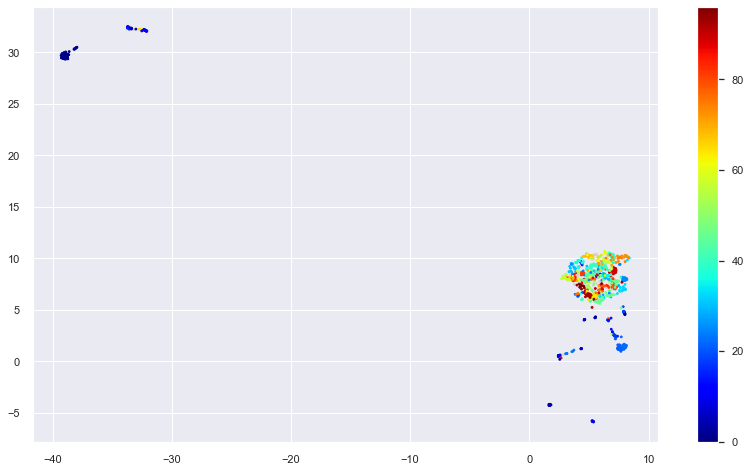

In [31]:
plot_clusters(embeddings_use, best_clusters_use)

/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_15583/229250936.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


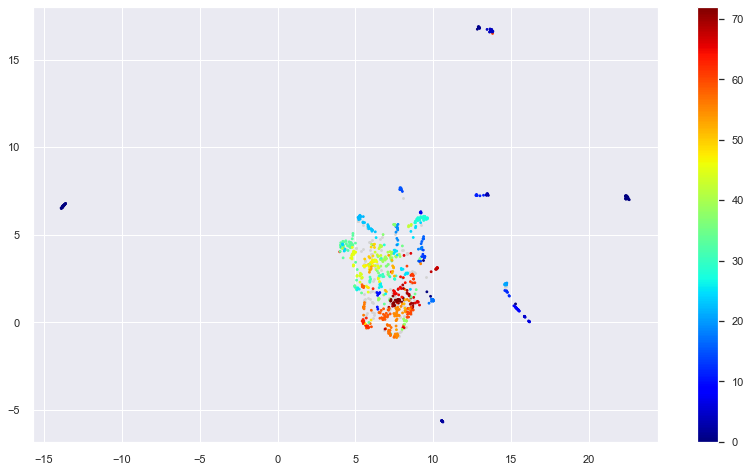

In [32]:
plot_clusters(embeddings_st1, best_clusters_st1)

/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_15583/229250936.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


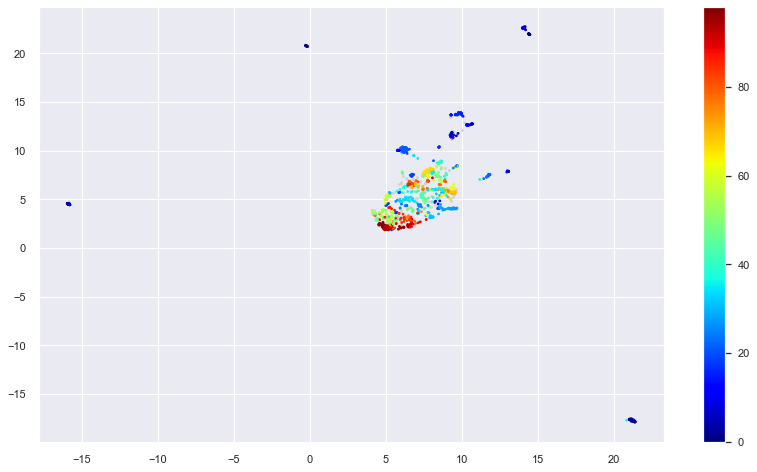

In [33]:
plot_clusters(embeddings_st2, best_clusters_st2)

/var/folders/7q/zq0k80m94v5408fgfvkddv880000gp/T/ipykernel_15583/229250936.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


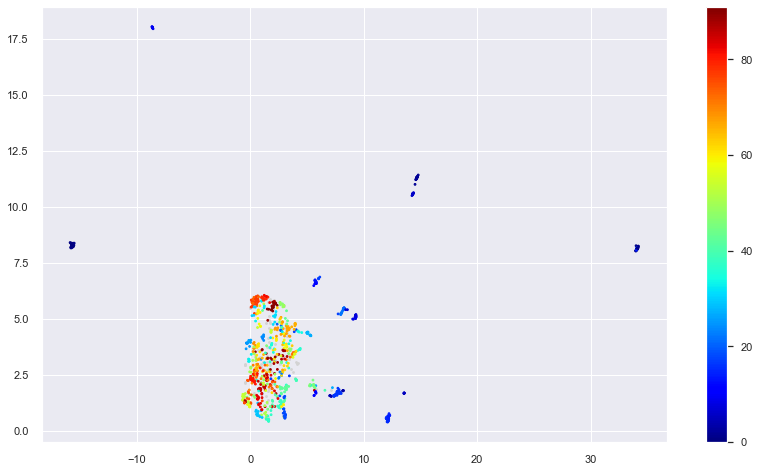

In [34]:
plot_clusters(embeddings_st3, best_clusters_st3)

# Compare clustering performance using ground truth labels

In [35]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st1, 
                'label_st2': best_clusters_st2,
                'label_st3': best_clusters_st3}

results_df = combine_results(data_sample[['Case title']], cluster_dict)
    
results_df.head()

,Case title,label_use,label_st1,label_st2,label_st3
1129,2205130050001971 genie,16,9,16,14
7071,Have access to both DBFS in S3 and Glue Catalo...,32,17,31,42
7431,External Jars not uploading in databricks,48,36,94,-1
6254,Streaming query Exception : exception thrown a...,14,31,18,53
2357,2204190030002027 - genie,1,5,16,15


In [36]:
model_dict = {'USE': ['label_use', best_params_use, trial_use],
              'all-mpnet-base-v2': ['label_st1', best_params_st1, best_trial_st1],
              'all-MiniLM-L6-v2': ['label_st2', best_params_st2, best_trial_st2],
              'all-distilroberta-v1': ['label_st3', best_params_st3, best_trial_st3]
               }

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
0,USE,0.242,0.784,0.062,88,3,5,3,42
3,all-distilroberta-v1,0.140,0.778,0.088,93,3,9,3,42
2,all-MiniLM-L6-v2,0.119,0.776,0.112,100,3,12,3,42
1,all-mpnet-base-v2,0.156,0.744,0.132,74,3,12,4,42


# Save cluster results

In [37]:
results_df.to_csv('sample_clustered.csv')

# Applying to the full dataset 
Demonstrate the same approach as above on the full  dataset. Several of the steps end up taking a bit longer to run on a dataset this size.

In [38]:
df.head()

,Case title
0,genie
1,genie
2,jproperties library installation issue
3,Union with Null
4,Spark ReadStream fails to infer schema


In [39]:
all_intents_full = list(df['Case title'])
len(all_intents_full)

7609

In [40]:
embeddings_use_10k= embed(model_use, 'use', all_intents_full)
embeddings_st1_10k = embed(model_st1, 'sentence transformer', all_intents_full)
embeddings_st2_10k = embed(model_st2, 'sentence transformer', all_intents_full)
embeddings_st3_10k = embed(model_st3, 'sentence transformer', all_intents_full)

In [41]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(3,16)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,16)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [42]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [23:27<00:00, 14.07s/trial, best loss: 0.1971349717439874]
best:
{'min_cluster_size': 15, 'n_components': 11, 'n_neighbors': 8, 'random_state': 42}
label count: 77


The fact that the cost function is still so high for the best model is a helpful indication that we need to modify the ranges used for the hyperparameters.



In [43]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(10,20)),
    "min_cluster_size": hp.choice('min_cluster_size', range(16,36)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [44]:
best_params_use, best_clusters_use, trials_use = bayesian_search(embeddings_use_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [26:23<00:00, 15.84s/trial, best loss: 0.16756472598238928]
best:
{'min_cluster_size': 27, 'n_components': 15, 'n_neighbors': 5, 'random_state': 42}
label count: 45


In [45]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [26:52<00:00, 16.12s/trial, best loss: 0.15744513076619793]
best:
{'min_cluster_size': 24, 'n_components': 18, 'n_neighbors': 3, 'random_state': 42}
label count: 66


In [46]:
best_params_st2, best_clusters_st2, trials_st2 = bayesian_search(embeddings_st2_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

 46%|████▌     | 46/100 [12:09<15:04, 16.75s/trial, best loss: 0.1720791168353266] 

/Users/ankush.singal/opt/anaconda3/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(



100%|██████████| 100/100 [25:23<00:00, 15.24s/trial, best loss: 0.16677618609541334]
best:
{'min_cluster_size': 30, 'n_components': 14, 'n_neighbors': 5, 'random_state': 42}
label count: 44


In [47]:
best_params_st3, best_clusters_st3, trials_st3 = bayesian_search(embeddings_st3_10k, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|██████████| 100/100 [30:54<00:00, 18.54s/trial, best loss: 0.15762255224076752]
best:
{'min_cluster_size': 23, 'n_components': 18, 'n_neighbors': 11, 'random_state': 42}
label count: 24


In [48]:
cluster_dict = {'label_use': best_clusters_use,
                'label_st1': best_clusters_st1, 
                'label_st2': best_clusters_st2,
                'label_st3': best_clusters_st3}

results_df = combine_results(df[['Case title']], cluster_dict)
    
model_dict = {'USE': ['label_use', best_params_use, trials_use],
              'all-mpnet-base-v2': ['label_st1', best_params_st1, trials_st1],
              'all-MiniLM-L6-v2': ['label_st2', best_params_st2, trials_st2],
              'all-distilroberta-v1': ['label_st3', best_params_st3, trials_st3]
               }

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
1,all-mpnet-base-v2,0.022,0.581,0.157445,66,3,18,24,42
2,all-MiniLM-L6-v2,0.073,0.563,0.166776,44,5,14,30,42
0,USE,0.058,0.541,0.167565,45,5,15,27,42
3,all-distilroberta-v1,0.005,0.279,0.157623,24,11,18,23,42
